<a href="https://colab.research.google.com/github/Herodegon/ECGR4105-Final_Project/blob/main/Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Meteostat Weather Prediction Model
## Written By: RJ Jock, Michael Delgrosso
## Last Updated: 8/7/2024
##
## This project gives the user a breakdown of the loss and accuracy of four different models for predicting average temperature
## on a given day using data obtained from Meteostat and curated into a usable form. These four models are:
## 1. SGDRegressor
## 2. Linear Neural Network
## 3. DecisionTreeRegressor
## 4. LinearSVR
##
## How To Use This Project:
## 1. Go down to block titled `Dataset`.
## 2. Change the dataset start and end dates, as well as location to your own preference
##     Note: If there are any issues with the chosen dates and location, or you would like to go back to the models defaults
##     please set all values to the default equivalents seen in the block above `Dataset`.
## 3. That's it! Once you've set these values, all models will update accordingly.
##    To analyze the results, see the blocks titled `Test` following the training blocks of each model.

In [2]:
pip install meteostat

In [3]:
import numpy as np
from datetime import datetime
from meteostat import Point, Daily, Hourly
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [4]:
dataset_start_default = datetime(2022, 1, 1)
dataset_end_default = datetime(2024, 12, 31)
dataset_location_default = Point(35.2271, -80.8431)

In [5]:
### Dataset: Constructed from date `dataset_start` to date `dataset_end` using data from weather station closest to `dataset_location` coordinates

# Enter the first date of the dataset
dataset_start = datetime(2022, 1, 1)

# Enter the last date of the dataset
dataset_end = datetime(2024, 12, 31)

# Enter the coordinates of the location you would like to train from (set to Charlotte by default)
dataset_location = Point(35.2271, -80.8431)
dataset_test_date = datetime(2024,8,7)

          tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                   
1|2022    20.5  18.3  25.6   3.3   0.0  211.0  21.6   NaN  1010.2   NaN
2|2022    19.8  15.0  21.7  12.7   0.0  206.0  18.4   NaN  1008.8   NaN
3|2022    10.7  -1.0  15.0  45.5   0.0    3.0  22.0   NaN  1014.1   NaN
4|2022     2.7  -2.1   7.8   0.0   0.0   98.0  10.8   NaN  1028.3   NaN
5|2022     7.6   3.3  15.6   0.0   0.0  247.0   9.4   NaN  1016.8   NaN
...        ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
361|2022   2.8  -2.1   9.4   0.0   0.0  344.0   3.2   NaN  1025.5   NaN
362|2022   4.1  -4.9  12.8   0.0   0.0  191.0   6.5   NaN  1027.1   NaN
363|2022   6.9  -2.7  17.8   0.0   0.0  242.0   6.1   NaN  1028.5   NaN
364|2022   9.4   1.1  15.0   0.0   0.0   10.0   6.1   NaN  1025.0   NaN
365|2022  12.7  11.1  15.0   9.1   0.0  220.0   7.6   NaN  1016.3   NaN

[365 rows x 10 columns]


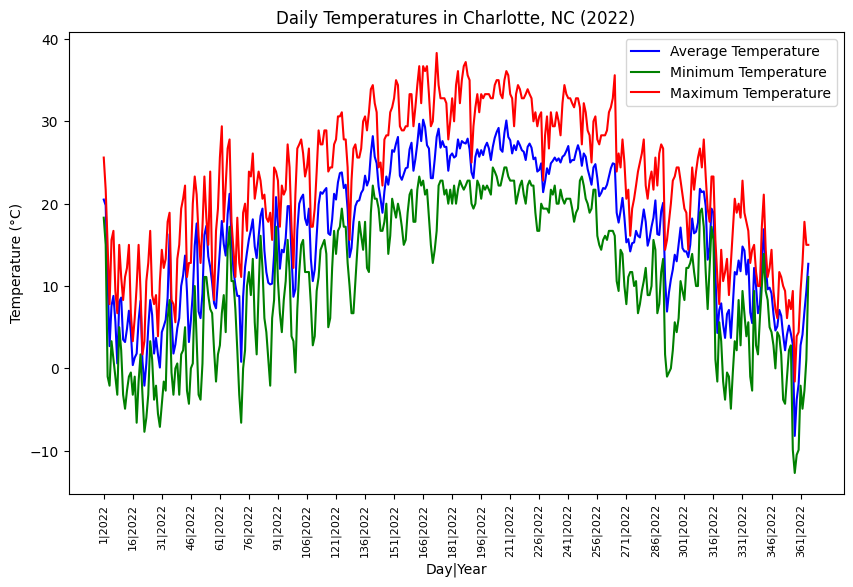

In [6]:
# Set time period for 2022
start_2022 = datetime(2022, 1, 1)
end_2022 = datetime(2022, 12, 31)

# Create Point for location (Charlotte, NC)
location = Point(35.2271, -80.8431)

# Get daily data for 2022
data_2022 = Daily(location, start_2022, end_2022)
data_2022 = data_2022.fetch()

# Format the index to "day|year"
data_2022.index = data_2022.index.strftime('%-j|%Y')

# Convert to NumPy array
data_array_2022 = data_2022.to_numpy()

# Print data as a table
print(data_2022)

# Plotting the data for 2022
plt.figure(figsize=(10, 6))

# Plot average temperature
plt.plot(data_2022.index, data_2022['tavg'], label='Average Temperature', color='blue')

# Plot minimum temperature
plt.plot(data_2022.index, data_2022['tmin'], label='Minimum Temperature', color='green')

# Plot maximum temperature
plt.plot(data_2022.index, data_2022['tmax'], label='Maximum Temperature', color='red')

# Set x-axis ticks to be in increments of 30 days
ticks = np.arange(0, len(data_2022.index), 15)
plt.xticks(ticks, data_2022.index[ticks], rotation=90, fontsize=8)

# Add titles and labels
plt.title('Daily Temperatures in Charlotte, NC (2022)')
plt.xlabel('Day|Year')
plt.ylabel('Temperature (°C)')
plt.legend()

# Show the plot
plt.show()

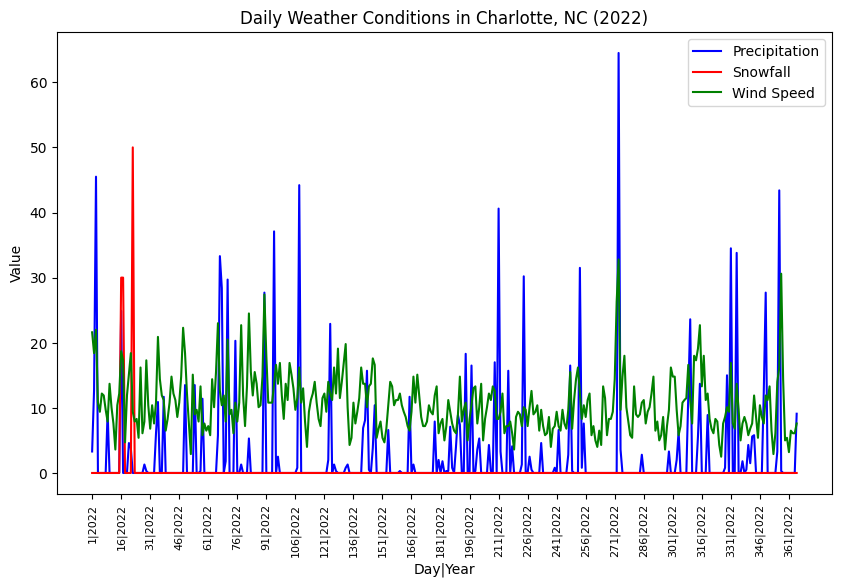

In [7]:
# Plotting the data for 2022
plt.figure(figsize=(10, 6))

plt.plot(data_2022.index, data_2022['prcp'], label='Precipitation',color='blue')
plt.plot(data_2022.index, data_2022['snow'], label='Snowfall',color='red')
plt.plot(data_2022.index, data_2022['wspd'], label='Wind Speed',color='green')
#plt.plot(data_2022.index, data_2022['pres'], label='Pressure',color='yellow')
#plt.plot(data_2022.index, data_2022['wdir'], label='Wind Direction',color='purple')

# Set x-axis ticks to be in increments of 30 days
ticks = np.arange(0, len(data_2022.index), 15)
plt.xticks(ticks, data_2022.index[ticks], rotation=90, fontsize=8)

plt.title('Daily Weather Conditions in Charlotte, NC (2022)')
plt.xlabel('Day|Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [8]:
def AverageHumidity(location,start_date,end_date):
  data_set = Hourly(location,start_date,end_date)
  data_set = data_set.fetch()
  data_set = data_set[['rhum']].fillna(0)

  daily_avg_humidity = data_set.resample('D').mean()

  return daily_avg_humidity

In [9]:
### Start of Training

# Training and validation
# Set time period for 2022
start = dataset_start
end = dataset_end

test_date = dataset_test_date    # Date for test predictions

# Create Point for location (Charlotte, NC)
location = dataset_location

# Get daily data for 2022
data = Daily(location, start, end)
data = data.fetch()

data_rhum = AverageHumidity(location,start,end)
data = data.join(data_rhum)

labels1 = ['tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'rhum']

# Prepare features and target
features1 = data[labels1].fillna(0)
target1 = data[['tavg']].fillna(0)

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

def Training_Loop_1(X_train,X_val,Y_train,Y_val,n_epoch,model):
  train_loss_history = np.zeros((n_epoch))
  valid_loss_history = np.zeros((n_epoch))

  train_score_history = np.zeros((n_epoch))
  valid_score_history = np.zeros((n_epoch))

  # Train the model
  for epoch in range(n_epoch):
    model.partial_fit(X_train,Y_train)

    # Predict on the validation set
    Y_pred_train = model.predict(X_train)
    Y_pred_valid = model.predict(X_val)

    # Calculate validation error
    mse_train = mean_squared_error(Y_train,Y_pred_train)
    mse_valid = mean_squared_error(Y_val,Y_pred_valid)

    train_loss_history[epoch] = mse_train
    valid_loss_history[epoch] = mse_valid

    # Calculate performance score
    score_train = model.score(X_train,Y_train)
    score_valid = model.score(X_val,Y_val)

    train_score_history[epoch] = score_train
    valid_score_history[epoch] = score_valid

  return model, train_loss_history, valid_loss_history, train_score_history, valid_score_history

def PlotLossHistory(n_epoch,train_loss_history,valid_loss_history,label):
  plt.figure(figsize=(10, 6))
  plt.plot(range(n_epoch), train_loss_history, label='Training Loss')
  plt.plot(range(n_epoch), valid_loss_history, label='Validation Loss')
  plt.title(f'Training and Validation Loss For {label}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def PlotPerformance(n_epoch,train_score_history,valid_score_history,label):
  plt.figure(figsize=(10, 6))
  plt.plot(range(n_epoch), train_score_history, label='Training Score')
  plt.plot(range(n_epoch), valid_score_history, label='Validation Score')
  plt.title(f'Training and Validation Score For {label}')
  plt.xlabel('Epoch')
  plt.ylabel('R2 Score')
  plt.legend()
  plt.show()

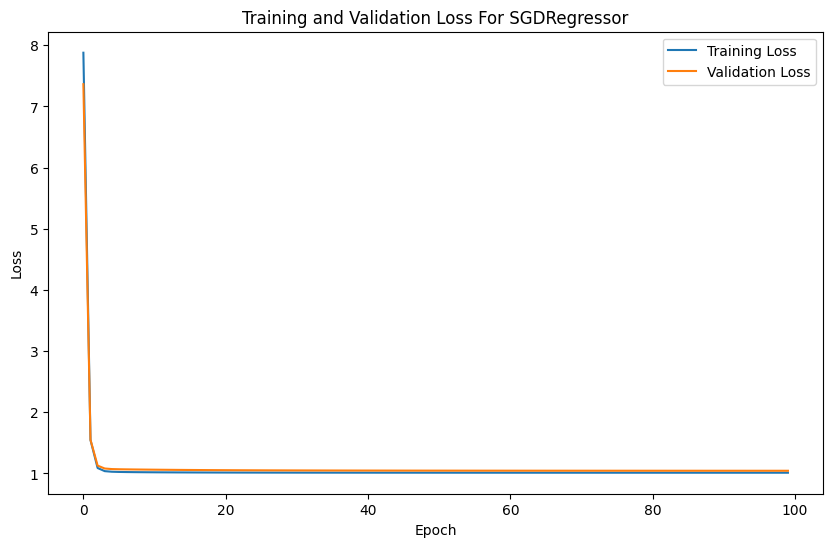

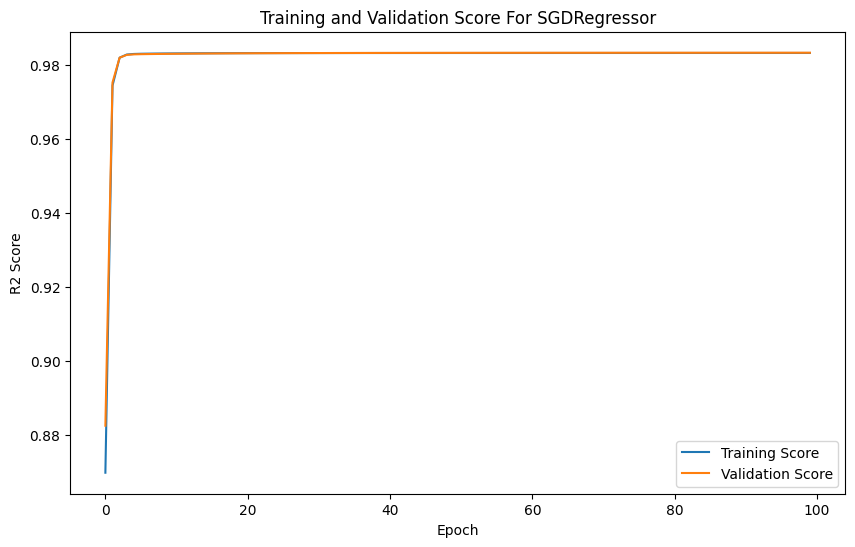

In [11]:
# Model 1: SGDRegressor
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features1, target1, test_size=0.2, random_state=0)
Y_train = Y_train.values.ravel()
Y_val = Y_val.values.ravel()

sc_X_tavg = StandardScaler()
X_train = sc_X_tavg.fit_transform(X_train)
X_val = sc_X_tavg.transform(X_val)

n_epoch = 100
model_tavg = SGDRegressor(warm_start=True,random_state=0)
model_tavg, train_loss_history, valid_loss_history, train_score_history, valid_score_history = Training_Loop_1(X_train,X_val,Y_train,Y_val,n_epoch,model_tavg)

PlotLossHistory(n_epoch,train_loss_history,valid_loss_history,'SGDRegressor')
PlotPerformance(n_epoch,train_score_history,valid_score_history,'SGDRegressor')

In [12]:
### Test: Calculates accuracy of SGDRegressor using date `test_date`
test_model = model_tavg
test_scaler = sc_X_tavg

test_start = test_date
test_end = test_start
test = Daily(location, test_start, test_end)
test = test.fetch()

test_rhum = AverageHumidity(location,test_start,test_end)
test = test.join(test_rhum)

test_features = test[labels1].fillna(0)
test_features = test_scaler.transform(test_features)
test_prediction = test_model.predict(test_features)

test_mse = mean_squared_error(test[['tavg']].values[0], test_prediction)
print("Accuracy of SGDRegressor:")
print("Predicted Average Temp = ", test_prediction[0])
print("Actual Average Temp = ", test[['tavg']].values[0,0])
print("MSE = ", test_mse)
print("Percent Error = ", 100.0*np.abs((test_prediction[0]-test[['tavg']].values[0,0])/test[['tavg']].values[0,0]))

Accuracy of SGDRegressor:
Predicted Average Temp =  26.366231053390607
Actual Average Temp =  25.7
MSE =  0.4438638165019582
Percent Error =  2.5923387291463316


In [13]:
import torch as torch
import torch.nn as nn

# Model 2: Linear Neural Network
# Split the data into training and validation sets

# Convert data to proper type

t_u = features1.values.astype(float)
t_c = target1.values.astype(float)

t_u = torch.tensor(t_u, dtype=torch.float32)
t_c = torch.tensor(t_c, dtype=torch.float32)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

sc_X_tavg2 = StandardScaler()
t_un_train = sc_X_tavg2.fit_transform(t_u_train)
t_un_val = sc_X_tavg2.transform(t_u_val)

t_un_train = torch.tensor(t_un_train, dtype=torch.float32)
t_un_val = torch.tensor(t_un_val, dtype=torch.float32)

print(t_un_train.shape)
print(t_c_train.shape)
print(t_un_val.shape)
print(t_c_val.shape)

torch.Size([768, 7])
torch.Size([768, 1])
torch.Size([191, 7])
torch.Size([191, 1])


In [14]:
def R2_Score(y_true, y_pred):
    total_sum_of_squares = torch.sum((y_true - y_true.mean())**2)
    residual_sum_of_squares = torch.sum((y_true - y_pred)**2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r2

def Training_Loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                   t_c_train, t_c_val):
  train_loss_history = np.zeros((n_epochs))
  valid_loss_history = np.zeros((n_epochs))
  train_score_history = np.zeros((n_epochs))
  valid_score_history = np.zeros((n_epochs))

  for epoch in range(1, n_epochs + 1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    train_loss_history[epoch-1] = loss_train.item()
    valid_loss_history[epoch-1] = loss_val.item()

    train_score_history[epoch-1] = R2_Score(t_c_train, t_p_train)
    valid_score_history[epoch-1] = R2_Score(t_c_val, t_p_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

  return train_loss_history, valid_loss_history, train_score_history, valid_score_history

Epoch 1, Training loss 371.8761, Validation loss 389.4077
Epoch 1000, Training loss 7.1563, Validation loss 64.4791
Epoch 2000, Training loss 1.2305, Validation loss 18.5648
Epoch 3000, Training loss 1.0910, Validation loss 9.2197
Epoch 4000, Training loss 1.0834, Validation loss 6.7423
Epoch 5000, Training loss 1.0816, Validation loss 6.0010


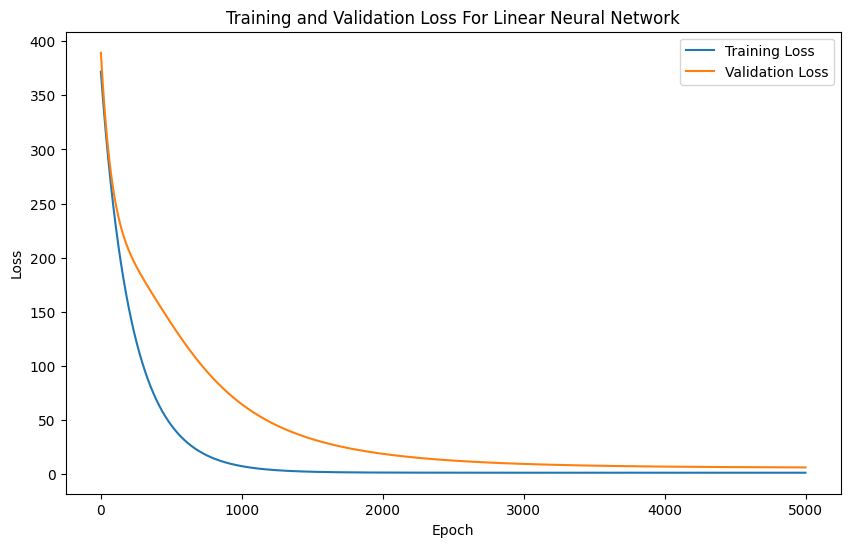

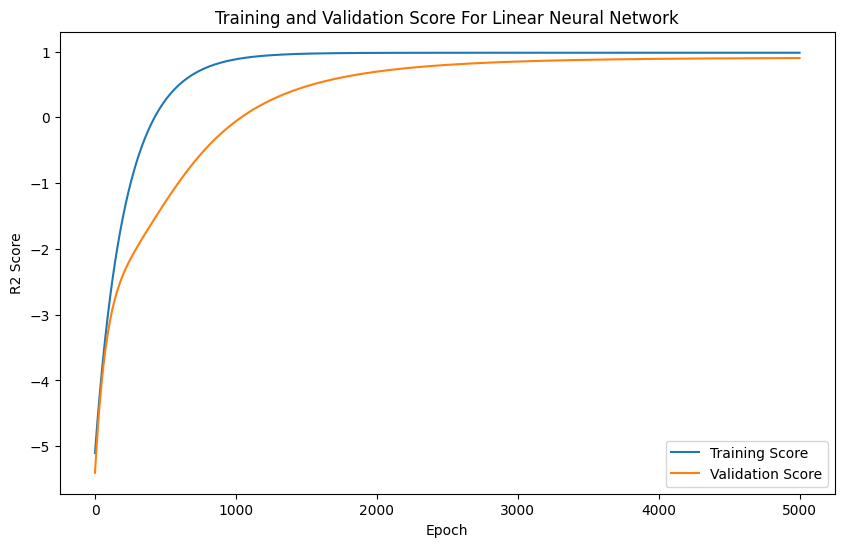

In [15]:
model_tavg2 = nn.Linear(t_u.shape[1], 1)
optimizer = torch.optim.SGD(model_tavg2.parameters(), lr=1e-3)

n_epoch = 5000
train_loss_history, valid_loss_history, train_score_history, valid_score_history = Training_Loop(
    n_epochs = n_epoch,
    optimizer = optimizer,
    model = model_tavg2,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

PlotLossHistory(n_epoch,train_loss_history,valid_loss_history,'Linear Neural Network')
PlotPerformance(n_epoch,train_score_history,valid_score_history,'Linear Neural Network')

In [16]:
### Test: Calculates accuracy of Neural Network using date `test_date`

test_model = model_tavg2
test_scaler = sc_X_tavg2

test_start = test_date
test_end = test_start
test = Daily(location, test_start, test_end)
test = test.fetch()

test_rhum = AverageHumidity(location,test_start,test_end)
test = test.join(test_rhum)

test_features = test[labels1].fillna(0)

test_t_u = test_features.values.astype(float)
test_t_u = torch.tensor(test_t_u, dtype=torch.float32)

test_t_un = test_scaler.transform(test_t_u)
test_t_un = torch.tensor(test_t_un, dtype=torch.float32)

test_tavg = torch.tensor(test[['tavg']].values.astype(float), dtype=torch.float32)

test_prediction = test_model(test_t_un)

test_mse = nn.MSELoss()(test_tavg, test_prediction)
print("Accuracy of Linear Neural Network:")
print("Predicted Average Temp = ", test_prediction.item())
print("Actual Average Temp = ", test_tavg.item())
print("MSE = ", test_mse.item())
print("Percent Error = ", 100.0 * torch.abs((test_prediction - test_tavg) / test_tavg).item())

Accuracy of Linear Neural Network:
Predicted Average Temp =  26.606292724609375
Actual Average Temp =  25.700000762939453
MSE =  0.8213651180267334
Percent Error =  3.52642759680748


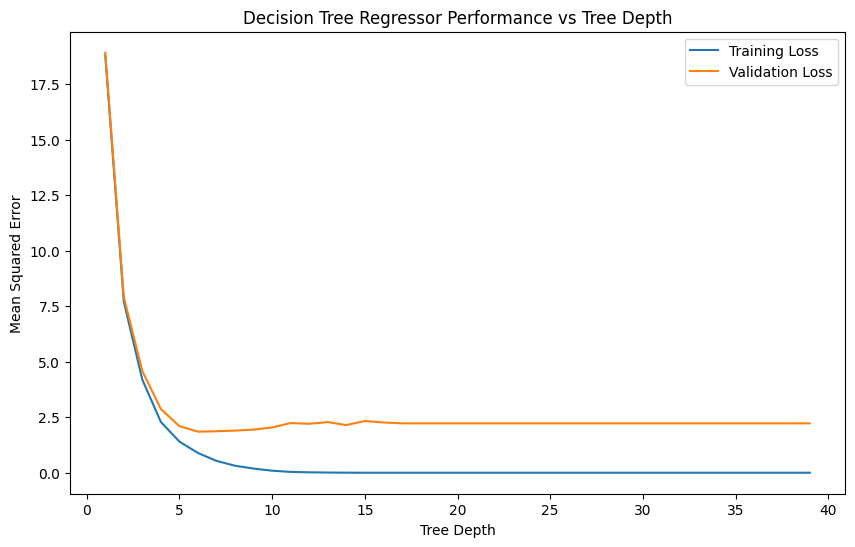

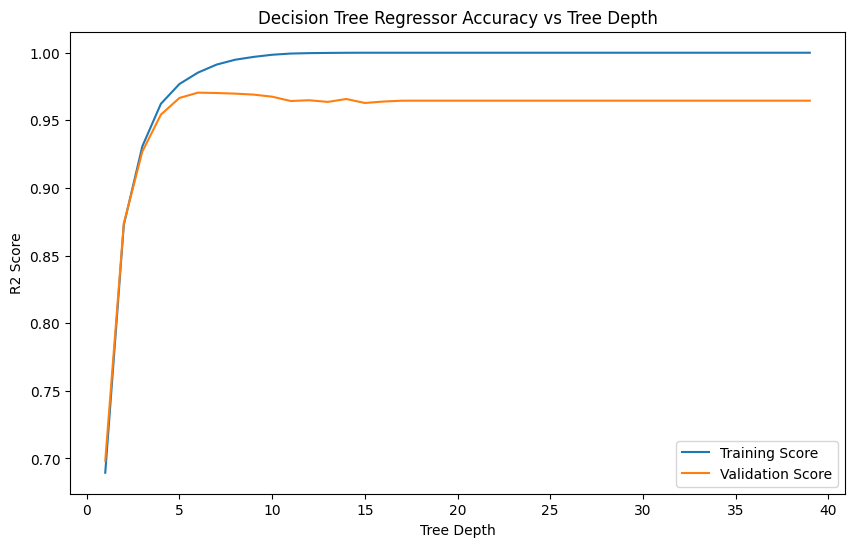

In [17]:
from sklearn.tree import DecisionTreeRegressor

# Model 3: DecisionTreeRegressor
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features1, target1, test_size=0.2, random_state=0)
Y_train = Y_train.values.ravel()
Y_val = Y_val.values.ravel()

sc_X_tavg3 = StandardScaler()
X_train = sc_X_tavg3.fit_transform(X_train)
X_val = sc_X_tavg3.transform(X_val)

max_depth_range = range(1,40)
train_loss_history = np.zeros((len(max_depth_range)))
valid_loss_history = np.zeros((len(max_depth_range)))
train_score_history = np.zeros((len(max_depth_range)))
valid_score_history = np.zeros((len(max_depth_range)))
for depth in max_depth_range:
    model_tavg3 = DecisionTreeRegressor(max_depth=depth, random_state=0)
    model_tavg3.fit(X_train, Y_train)

    Y_train_pred = model_tavg3.predict(X_train)
    Y_valid_pred = model_tavg3.predict(X_val)

    train_loss_history[depth-1] = mean_squared_error(Y_train, Y_train_pred)
    valid_loss_history[depth-1] = mean_squared_error(Y_val, Y_valid_pred)

    train_score_history[depth-1] = model_tavg3.score(X_train,Y_train)
    valid_score_history[depth-1] = model_tavg3.score(X_val,Y_val)

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_loss_history, label='Training Loss')
plt.plot(max_depth_range, valid_loss_history, label='Validation Loss')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Regressor Performance vs Tree Depth')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_score_history, label='Training Score')
plt.plot(max_depth_range, valid_score_history, label='Validation Score')
plt.xlabel('Tree Depth')
plt.ylabel('R2 Score')
plt.title('Decision Tree Regressor Accuracy vs Tree Depth')
plt.legend()
plt.show()

In [18]:
### Test: Calculates accuracy of DecisionTreeRegressor using date `test_date`

test_model = model_tavg3
test_scaler = sc_X_tavg3

test_start = test_date
test_end = test_start
test = Daily(location, test_start, test_end)
test = test.fetch()

test_rhum = AverageHumidity(location,test_start,test_end)
test = test.join(test_rhum)

test_features = test[labels1].fillna(0)
test_features = test_scaler.transform(test_features)
test_prediction = test_model.predict(test_features)

test_mse = mean_squared_error(test[['tavg']].values[0], test_prediction)
print("Accuracy of DecisionTreeRegressor:")
print("Predicted Average Temp = ", test_prediction[0])
print("Actual Average Temp = ", test[['tavg']].values[0,0])
print("MSE = ", test_mse)
print("Percent Error = ", 100.0*np.abs((test_prediction[0]-test[['tavg']].values[0,0])/test[['tavg']].values[0,0]))

Accuracy of DecisionTreeRegressor:
Predicted Average Temp =  25.7
Actual Average Temp =  25.7
MSE =  0.0
Percent Error =  0.0


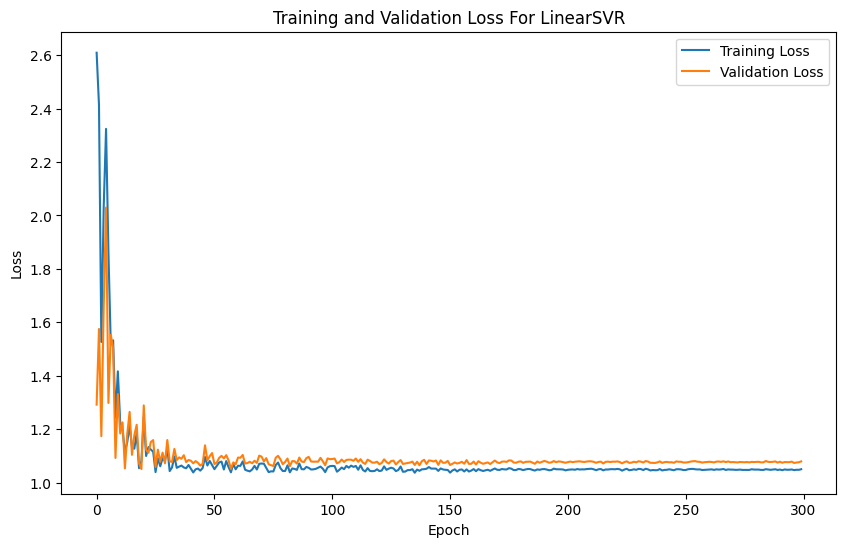

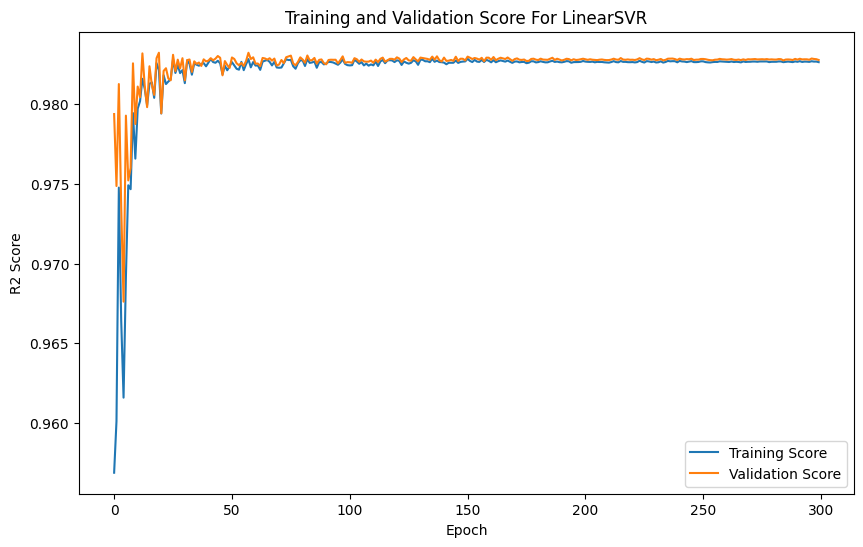

In [19]:
from sklearn.svm import LinearSVR

# Model 3: LinearSVR
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(features1, target1, test_size=0.2, random_state=0)
Y_train = Y_train.values.ravel()
Y_val = Y_val.values.ravel()

sc_X_tavg4 = StandardScaler()
X_train = sc_X_tavg4.fit_transform(X_train)
X_val = sc_X_tavg4.transform(X_val)

n_epoch = 300
train_loss_history = np.zeros(n_epoch)
valid_loss_history = np.zeros(n_epoch)
train_score_history = np.zeros(n_epoch)
valid_score_history = np.zeros(n_epoch)
for epoch in range(1,n_epoch+1):
    model_tavg4 = LinearSVR(max_iter=epoch,dual='auto',random_state=0)
    model_tavg4.fit(X_train, Y_train)

    Y_train_pred = model_tavg4.predict(X_train)
    Y_valid_pred = model_tavg4.predict(X_val)

    train_loss_history[epoch-1] = mean_squared_error(Y_train, Y_train_pred)
    valid_loss_history[epoch-1] = mean_squared_error(Y_val, Y_valid_pred)

    train_score_history[epoch-1] = model_tavg4.score(X_train,Y_train)
    valid_score_history[epoch-1] = model_tavg4.score(X_val,Y_val)

PlotLossHistory(n_epoch,train_loss_history,valid_loss_history,'LinearSVR')
PlotPerformance(n_epoch,train_score_history,valid_score_history,'LinearSVR')

In [20]:
### Test: Calculates accuracy of DecisionTreeRegressor using date `test_date`

test_model = model_tavg4
test_scaler = sc_X_tavg4

test_start = test_date
test_end = test_start
test = Daily(location, test_start, test_end)
test = test.fetch()

test_rhum = AverageHumidity(location,test_start,test_end)
test = test.join(test_rhum)

test_features = test[labels1].fillna(0)
test_features = test_scaler.transform(test_features)
test_prediction = test_model.predict(test_features)

test_mse = mean_squared_error(test[['tavg']].values[0], test_prediction)
print("Accuracy of LinearSVR:")
print("Predicted Average Temp = ", test_prediction[0])
print("Actual Average Temp = ", test[['tavg']].values[0,0])
print("MSE = ", test_mse)
print("Percent Error = ", 100.0*np.abs((test_prediction[0]-test[['tavg']].values[0,0])/test[['tavg']].values[0,0]))

Accuracy of LinearSVR:
Predicted Average Temp =  25.84874061049294
Actual Average Temp =  25.7
MSE =  0.02212376920981245
Percent Error =  0.5787572392721395
